In [1]:
import os
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Load the dataset
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dataset")
data = pd.read_excel(f"{data_path}/data_transformed.xlsx")
# Drop the unnamed column as it is unnecessary for correlation analysis
data = data.drop(columns=['Unnamed: 0'])

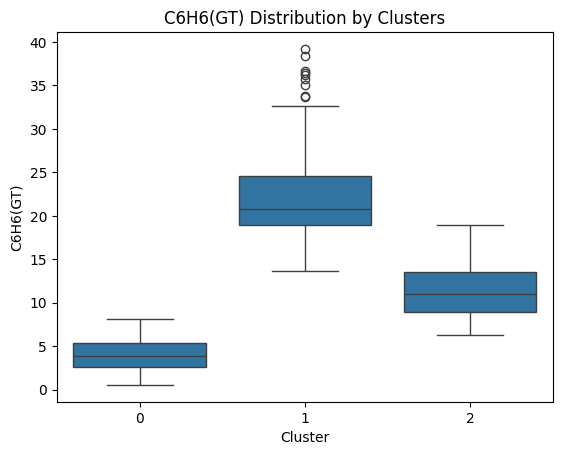

In [3]:
# Select relevant predictors for clustering (ignoring non-informative columns like 'Unnamed: 0')
predictor_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
                    'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

# Standardize the predictor variables for clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[predictor_columns])

# Apply K-Means clustering to find natural groups in the data
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters as an example
data['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the distribution of the target variable within the clusters
sns.boxplot(x='cluster', y='C6H6(GT)', data=data)
plt.title("C6H6(GT) Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("C6H6(GT)")
plt.show()

# Summary statistics for each cluster
cluster_summary = data.groupby("cluster")[predictor_columns + ['C6H6(GT)']].mean()

In [4]:
cluster_summary

,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)
cluster,,,,,,,,,,,,,
0,1.099363,981.406847,68.799363,698.687102,71.461783,1229.687367,70.652866,1321.282643,682.866242,12.771842,53.457511,0.763095,3.981506
1,4.513295,1551.542389,545.693642,1349.135356,264.479769,658.124277,137.797688,2050.468690,1598.689788,17.746869,48.152698,0.936480,22.175780
2,2.412941,1241.835049,220.735294,1017.883578,148.476471,872.267402,108.502941,1629.426716,1099.391667,17.119167,45.435024,0.842111,11.241603


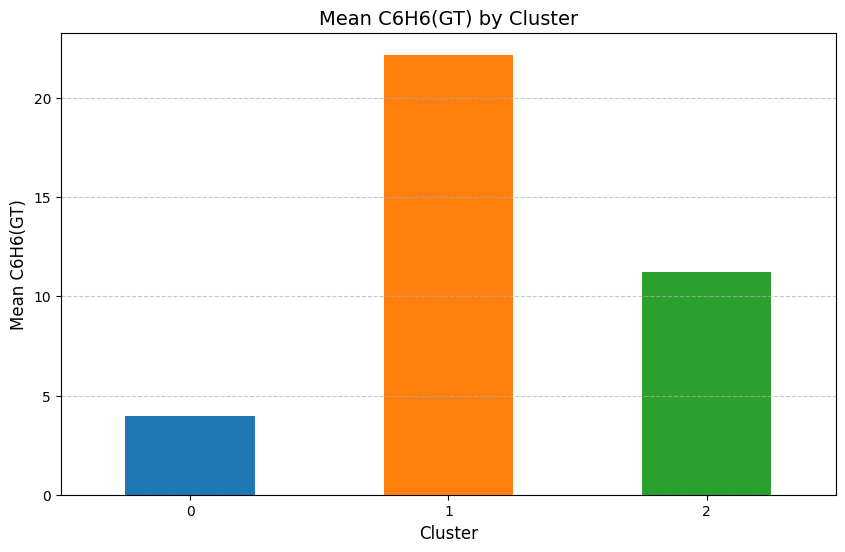

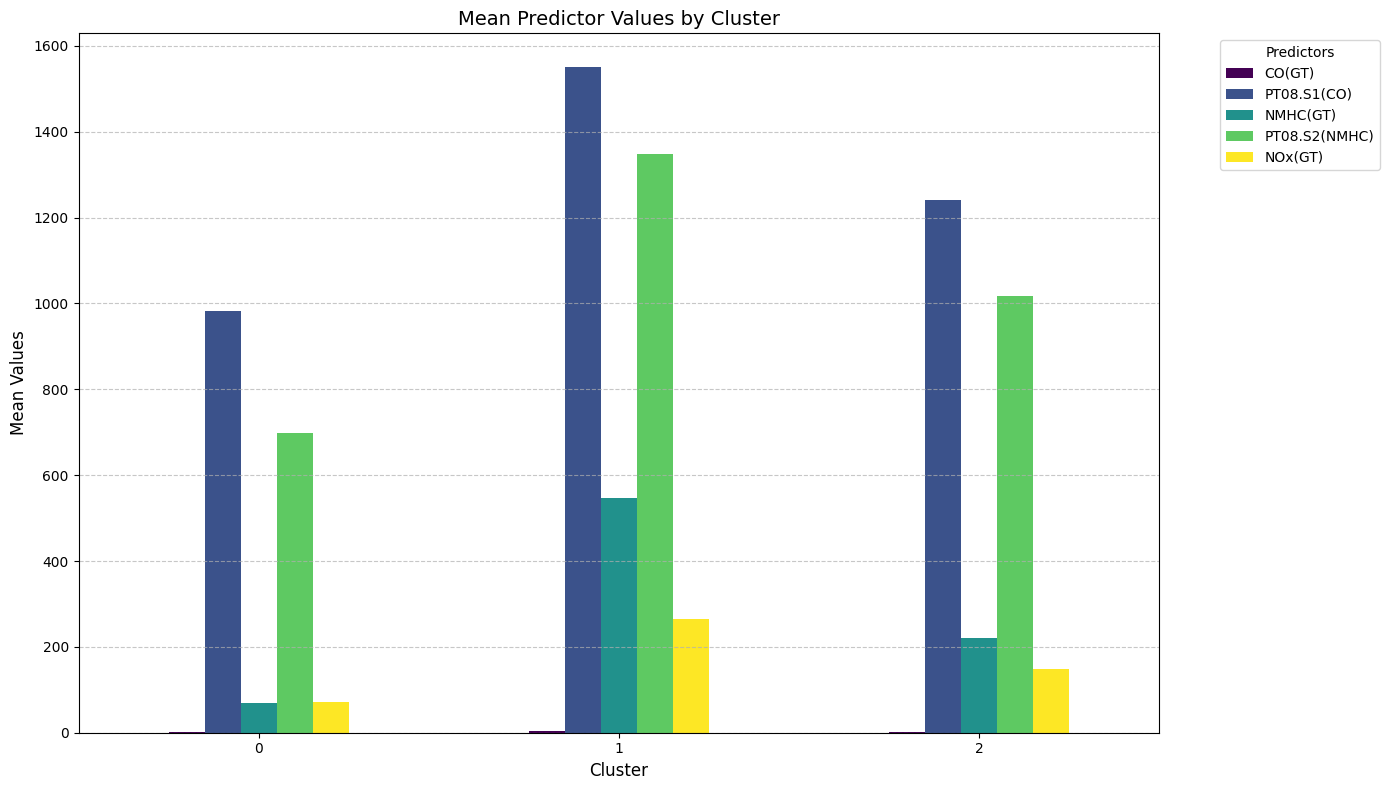

In [5]:
# Compute the mean values for each cluster
cluster_means = data.groupby("cluster")[predictor_columns + ["C6H6(GT)"]].mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means["C6H6(GT)"].plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
ax.set_title("Mean C6H6(GT) by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean C6H6(GT)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()

# Visualize a subset of predictors by cluster
fig, ax = plt.subplots(figsize=(14, 8))
cluster_means[predictor_columns[:5]].plot(kind="bar", ax=ax, colormap="viridis")
ax.set_title("Mean Predictor Values by Cluster", fontsize=14)
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Mean Values", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title="Predictors", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the priors
az.plot_dist(prior_predictive["beta"], label="Beta (Coefficients)")
plt.title("Prior Distribution for Beta (Coefficients)")
plt.xlabel("Beta Values")
plt.legend()
plt.show()

# Visualize the prior predictive for the target variable
plt.hist(prior_predictive["target"], bins=15, density=True, alpha=0.5, label="Prior Predictive")
plt.title("Prior Predictive Check for Target (C6H6(GT))")
plt.xlabel("Target Variable")
plt.ylabel("Density")
plt.legend()
plt.show()

Hierarchical Modelling

Prior Model

In [20]:
# Define the hierarchical Bayesian model for prior predictive checks
with pm.Model() as prior_hierarchical_model:
    # Hyperpriors for group-level parameters
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
    sigma_beta = pm.HalfCauchy("sigma_beta", beta=2, shape=len(predictor_columns))  # Population-level variance

    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
    sigma_intercept = pm.HalfCauchy("sigma_intercept", beta=2)  # Population-level variance

    # Group-level parameters
    intercept = pm.Normal("intercept", mu=mu_intercept, sigma=sigma_intercept, shape=n_groups)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=(n_groups, len(predictor_columns)))

    # Linear predictor for each group
    mu = pm.math.exp(intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1))

    # Shape parameter for Gamma likelihood
    alpha = pm.HalfCauchy("alpha", beta=2)

    # Likelihood for prior predictive (remove observed data)
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu)

    # Sample prior predictive
    prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, beta, intercept, mu_beta, mu_intercept, sigma_beta, sigma_intercept, target]


In [22]:
prior_predictive

Inference data with groups:
	> prior

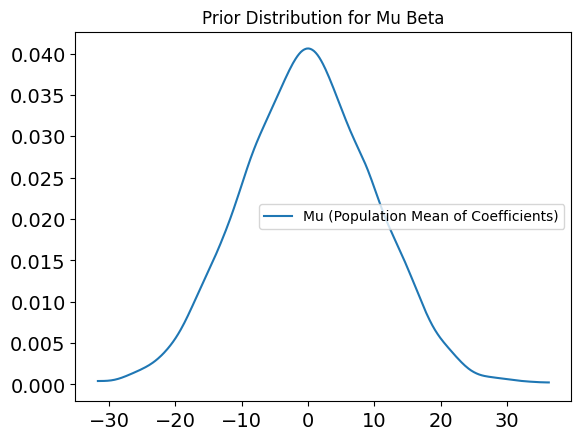

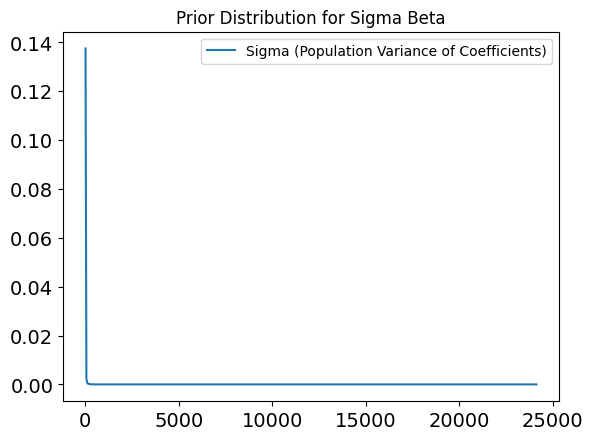

In [24]:
# Plot hyperpriors
az.plot_dist(prior_predictive["prior"]["mu_beta"], label="Mu (Population Mean of Coefficients)")
plt.title("Prior Distribution for Mu Beta")
plt.legend()
plt.show()

az.plot_dist(prior_predictive["prior"]["sigma_beta"], label="Sigma (Population Variance of Coefficients)")
plt.title("Prior Distribution for Sigma Beta")
plt.legend()
plt.show()

In [36]:
beta_shape = prior_predictive["prior"]["beta"].values.shape
print(f"Shape of beta: {beta_shape}")

Shape of beta: (1, 500, 3, 12)


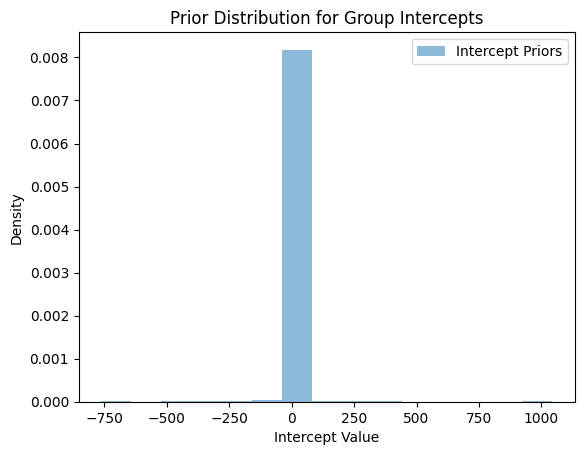

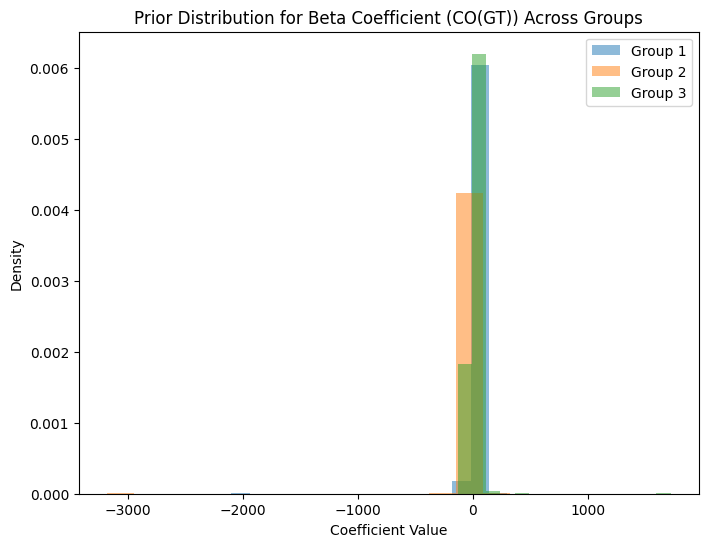

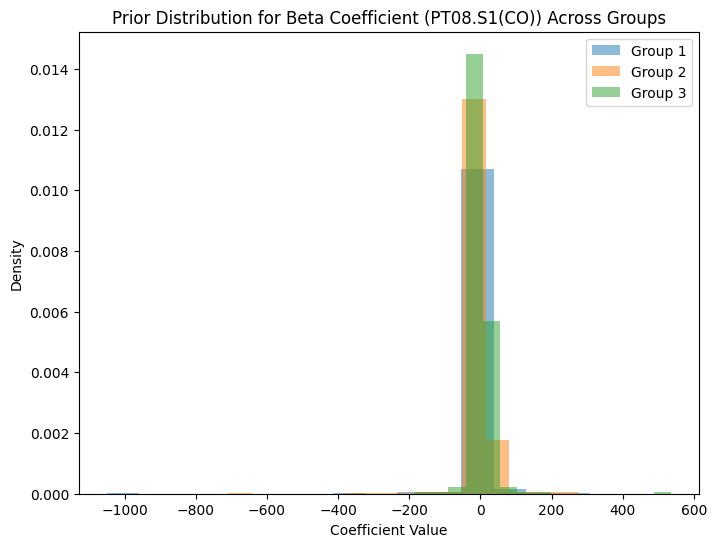

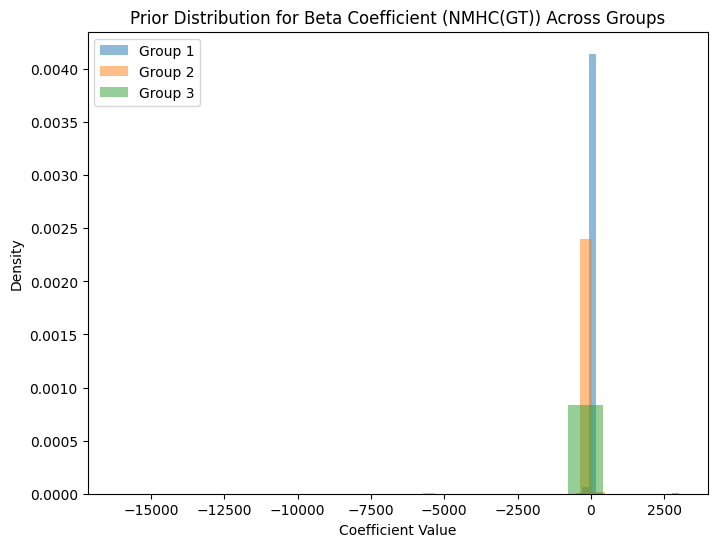

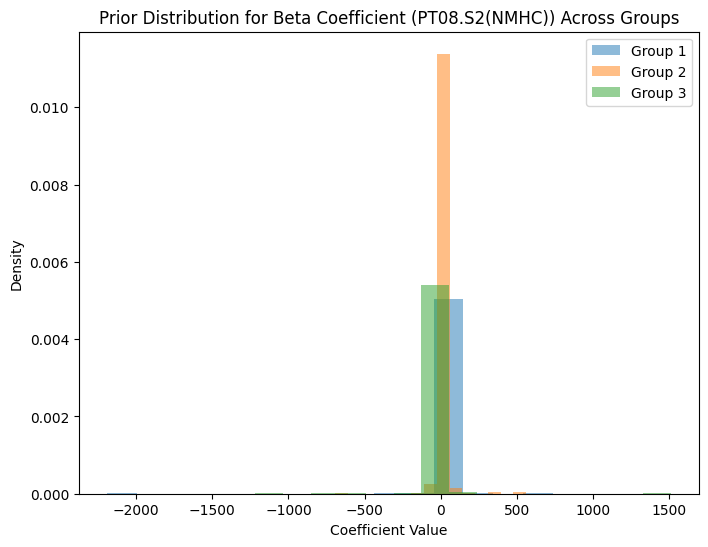

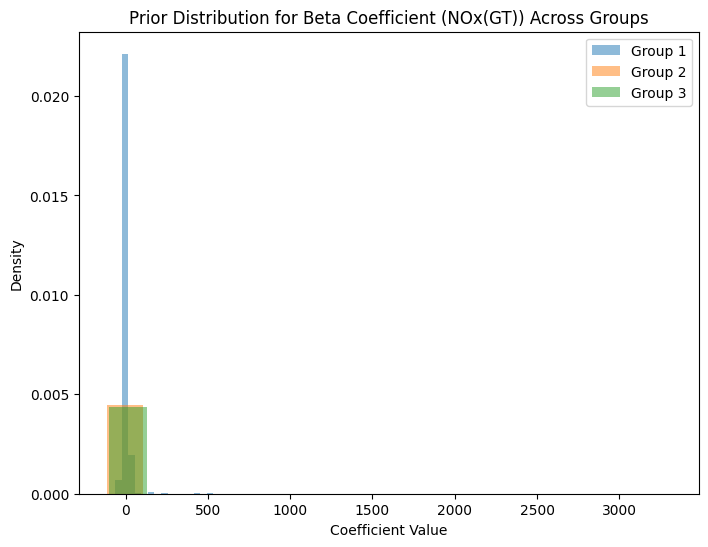

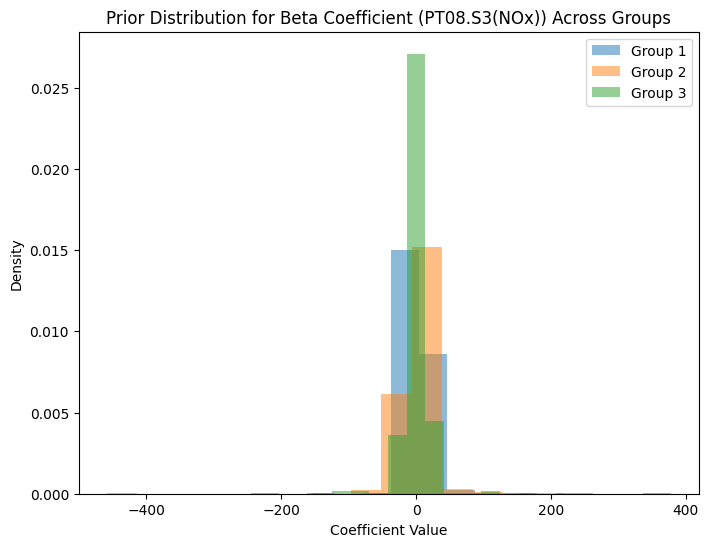

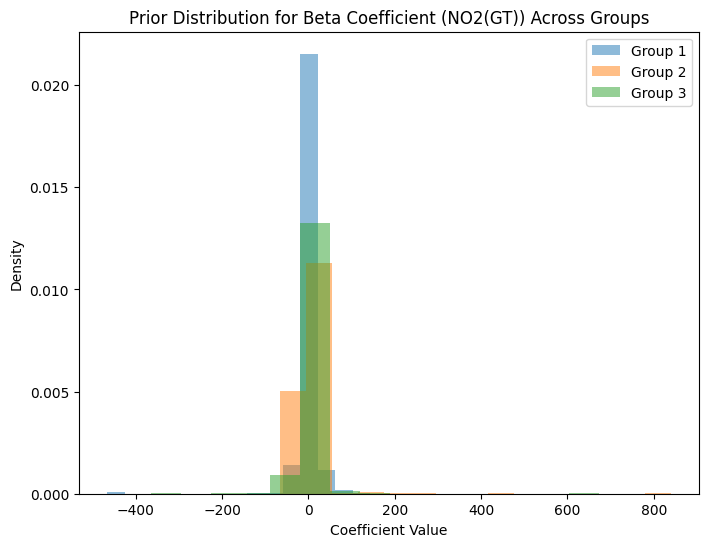

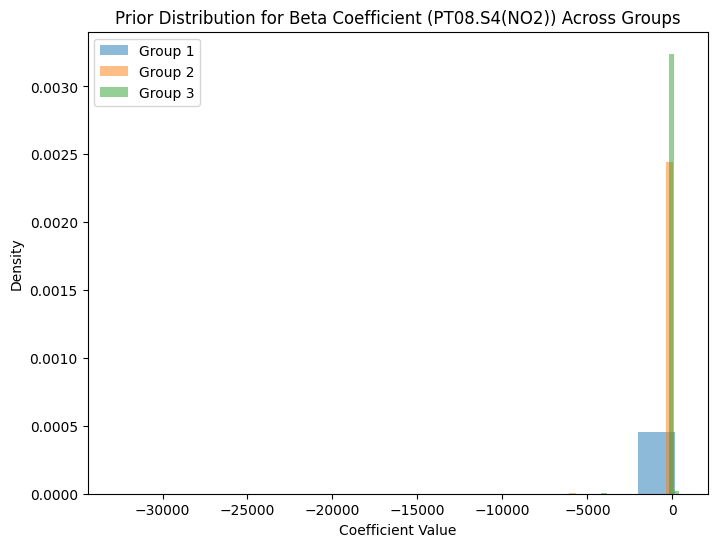

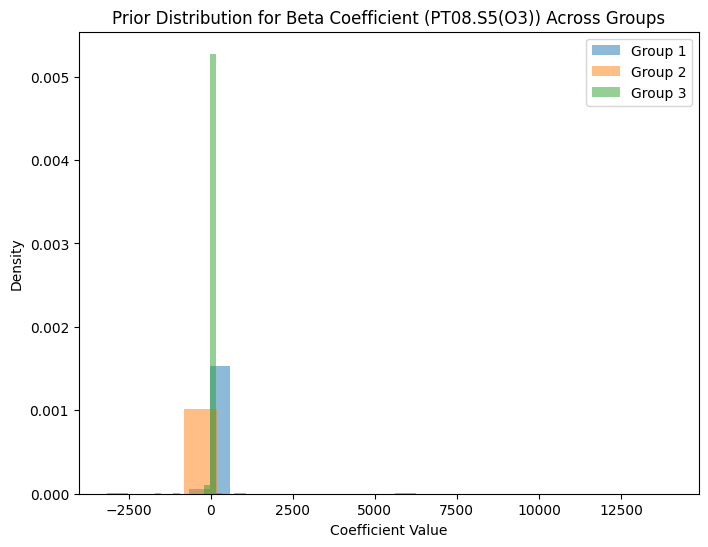

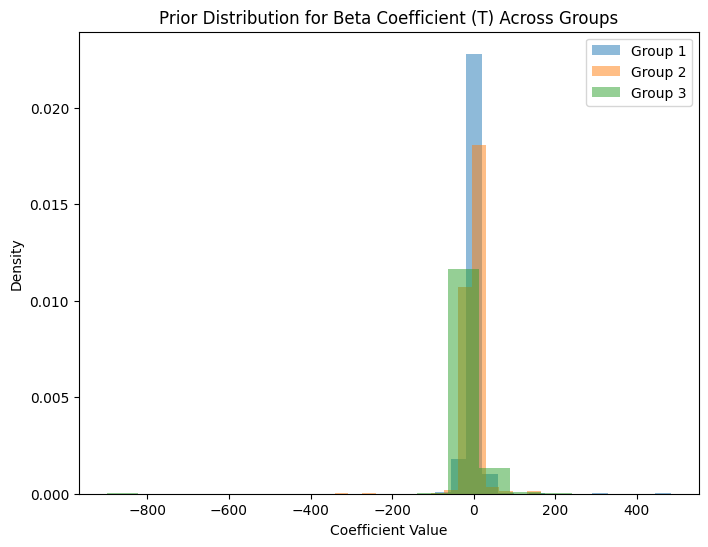

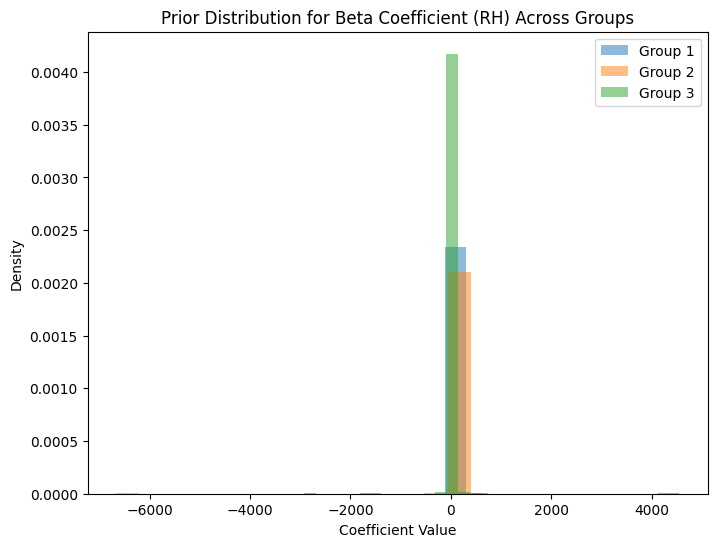

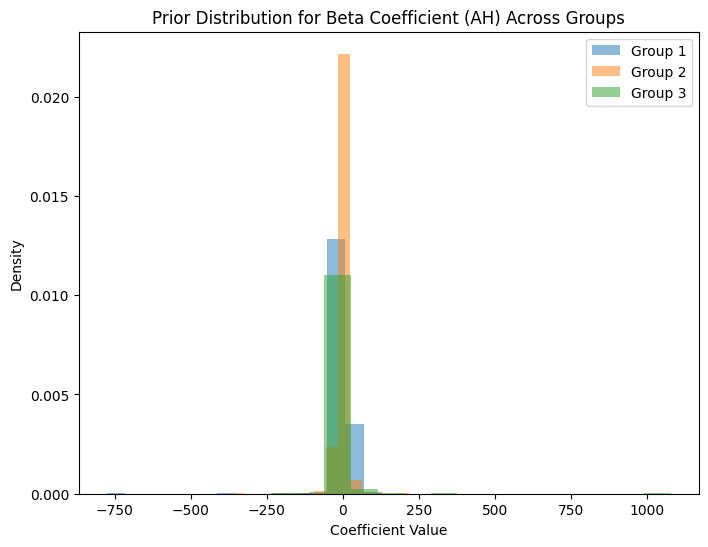

In [37]:
# Plot intercept priors
plt.hist(prior_predictive["prior"]["intercept"].values.flatten(), bins=15, density=True, alpha=0.5, label="Intercept Priors")
plt.title("Prior Distribution for Group Intercepts")
plt.xlabel("Intercept Value")
plt.ylabel("Density")
plt.legend()
plt.show()

beta_values = prior_predictive["prior"]["beta"].values.reshape(-1, beta_shape[2], beta_shape[3])  # Shape: (500, 3, 12)
# Plot coefficients (beta) priors
# Iterate over each predictor and group
for i, predictor in enumerate(predictor_columns):  # Loop through predictors
    plt.figure(figsize=(8, 6))
    for g in range(beta_shape[2]):  # Loop through groups
        plt.hist(beta_values[:, g, i], bins=15, density=True, alpha=0.5, label=f"Group {g+1}")
    plt.title(f"Prior Distribution for Beta Coefficient ({predictor}) Across Groups")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [44]:
prior_predictive["prior"]["target"]

<xarray.DataArray 'target' (chain: 1, draw: 500, target_dim_0: 827)> Size: 3MB
array([[[ 0., inf,  0., ...,  0.,  0., inf],
        [inf, inf, inf, ..., inf, inf,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., inf],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [inf, inf, inf, ...,  0.,  0.,  0.],
        [inf, inf, inf, ..., inf, inf,  0.]]])
Coordinates:
  * chain         (chain) int32 4B 0
  * draw          (draw) int32 2kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * target_dim_0  (target_dim_0) int32 3kB 0 1 2 3 4 5 ... 822 823 824 825 826

In [48]:
# Extract prior predictive samples for the target
target_prior = prior_predictive["prior"]["target"].values.flatten()

# Check for non-finite values
print("Any NaN values:", np.isnan(target_prior).any())
print("Any Inf values:", np.isinf(target_prior).any())
print("Max value:", np.max(target_prior))
print("Min value:", np.min(target_prior))

Any NaN values: True
Any Inf values: True
Max value: nan
Min value: nan


In [49]:
# Remove non-finite values
target_prior = target_prior[np.isfinite(target_prior)]

# Check the cleaned array
print("Cleaned target_prior length:", len(target_prior))

Cleaned target_prior length: 206594


In [51]:
print("Max value:", np.max(target_prior))
print("Min value:", np.min(target_prior))

Max value: 1.3507617779685612e+308
Min value: 0.0


In [52]:
# Replace infinities and NaNs with a high upper bound
target_prior = np.where(np.isfinite(target_prior), target_prior, np.nan)  # Replace infinities with NaN
target_prior = target_prior[~np.isnan(target_prior)]  # Remove NaN values

# Optionally clip extreme values (to make the range manageable)
upper_bound = 1e6  # Example upper limit
target_prior = np.clip(target_prior, a_min=0, a_max=upper_bound)

# Check the cleaned array
print("Cleaned target_prior length:", len(target_prior))

Cleaned target_prior length: 206594


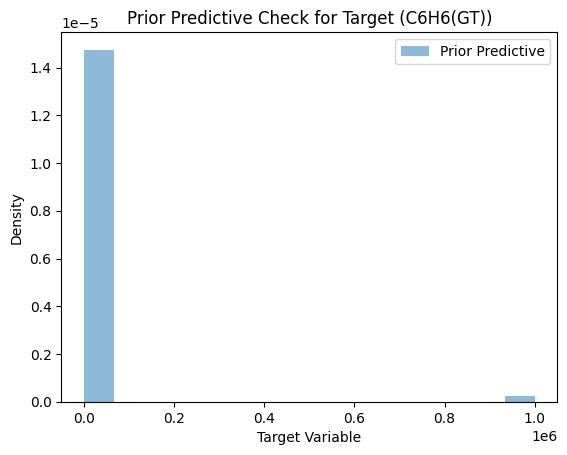

In [53]:
# Plot prior predictive distribution of the target variable
plt.hist(target_prior, bins=15, density=True, alpha=0.5, label="Prior Predictive")
plt.title("Prior Predictive Check for Target (C6H6(GT))")
plt.xlabel("Target Variable")
plt.ylabel("Density")
plt.legend()
plt.show()

Posterior Model

In [6]:
# Prepare data for hierarchical modeling
group_idx = data["cluster"].values  # Use clusters as the grouping variable
n_groups = len(np.unique(group_idx))  # Number of clusters/groups
X = data[predictor_columns].values  # Predictors
y = data["C6H6(GT)"].values  # Target variable

# Ensure the target variable is strictly positive
if (y <= 0).any():
    y += 0.001

# Define the hierarchical Bayesian model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group-level parameters
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=10, shape=len(predictor_columns))  # Population-level mean for coefficients
    sigma_beta = pm.HalfCauchy("sigma_beta", beta=2, shape=len(predictor_columns))  # Population-level variance

    mu_intercept = pm.Normal("mu_intercept", mu=0, sigma=10)  # Population-level mean for intercept
    sigma_intercept = pm.HalfCauchy("sigma_intercept", beta=2)  # Population-level variance

    # Group-level parameters
    intercept = pm.Normal("intercept", mu=mu_intercept, sigma=sigma_intercept, shape=n_groups)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=(n_groups, len(predictor_columns)))

    # Linear predictor for each group
    mu = pm.math.exp(intercept[group_idx] + pm.math.sum(beta[group_idx] * X, axis=1))

    # Shape parameter for Gamma likelihood
    alpha = pm.HalfCauchy("alpha", beta=2)

    # Likelihood
    target = pm.Gamma("target", alpha=alpha, beta=alpha / mu, observed=y)

    # Sample the posterior
    hierarchical_trace = pm.sample(1000, tune=500, init="adapt_diag", return_inferencedata=True)

    # Posterior predictive checks
    hierarchical_posterior_predictive = pm.sample_posterior_predictive(hierarchical_trace, model=hierarchical_model)

Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_beta, sigma_beta, mu_intercept, sigma_intercept, intercept, beta, alpha]


Output()

Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 447 seconds.
There were 1517 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [target]


Output()

In [7]:
hierarchical_posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data

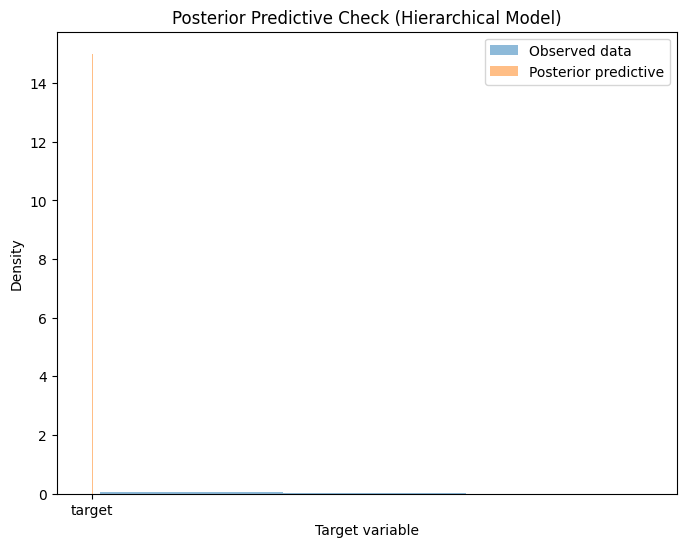

In [8]:
# Visualize the posterior predictive checks
_, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(y, bins=15, density=True, alpha=0.5, label="Observed data")
ax.hist(hierarchical_posterior_predictive["posterior_predictive"], bins=15, density=True, alpha=0.5, label="Posterior predictive")
ax.set_xlabel("Target variable")
ax.set_ylabel("Density")
ax.legend()
plt.title("Posterior Predictive Check (Hierarchical Model)")
plt.show()

In [15]:
posterior_samples = hierarchical_posterior_predictive["posterior_predictive"]["target"].mean(dim="draw").values

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


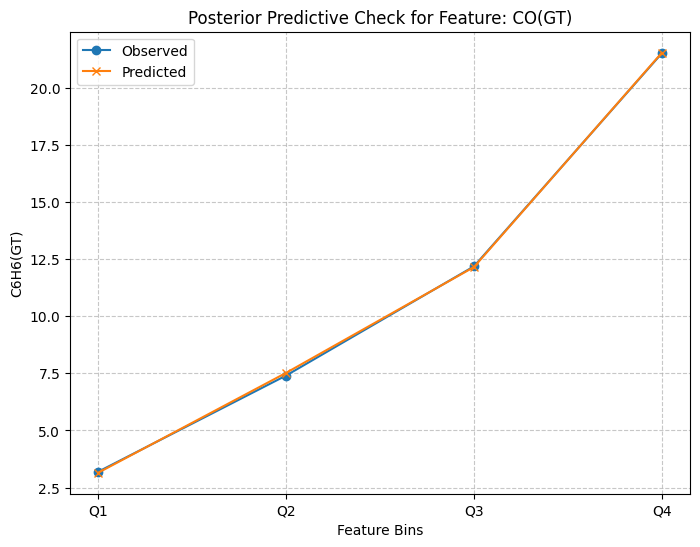

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


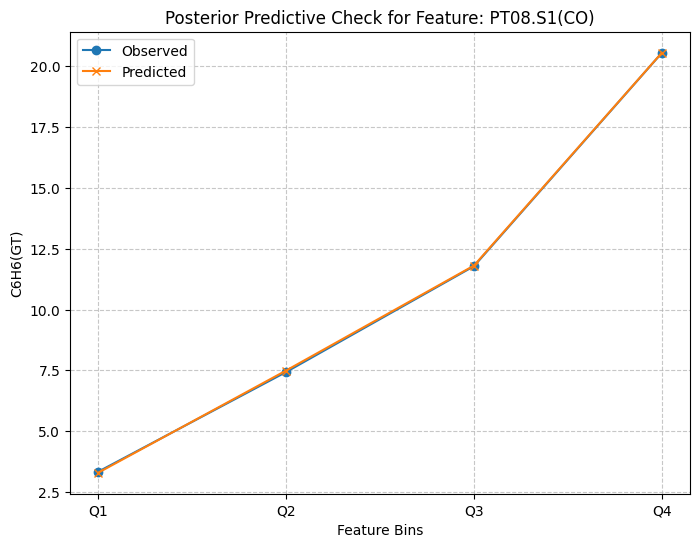

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


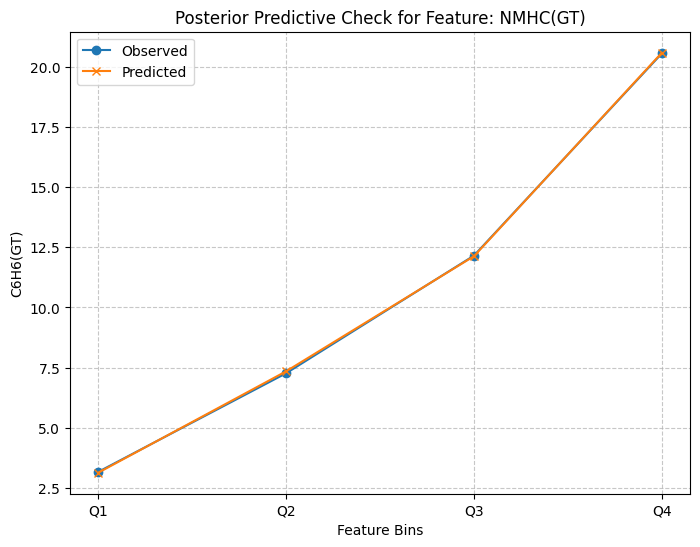

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


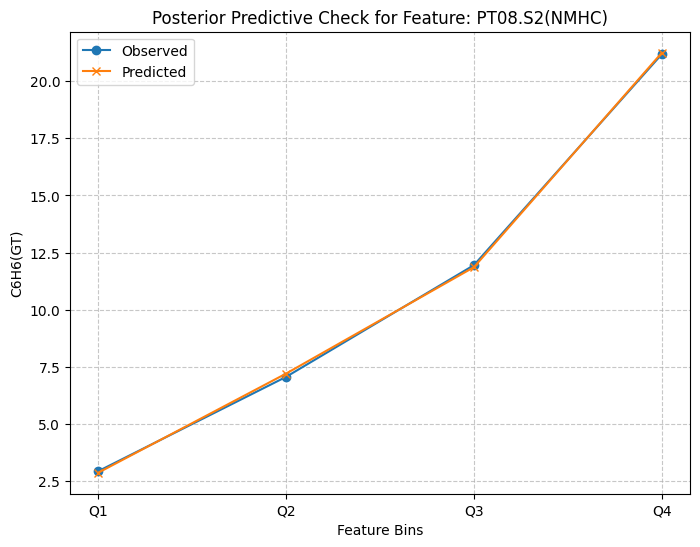

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


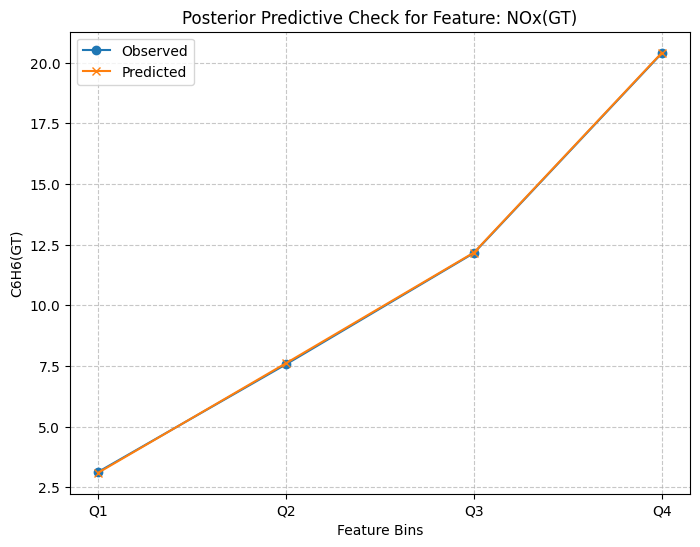

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


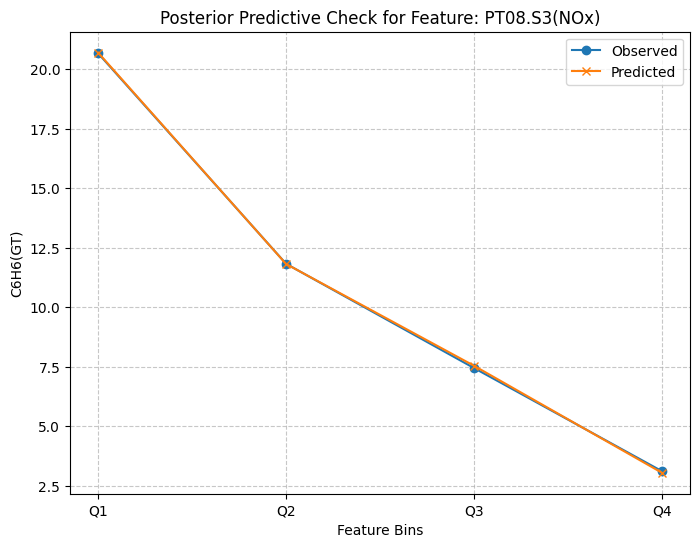

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


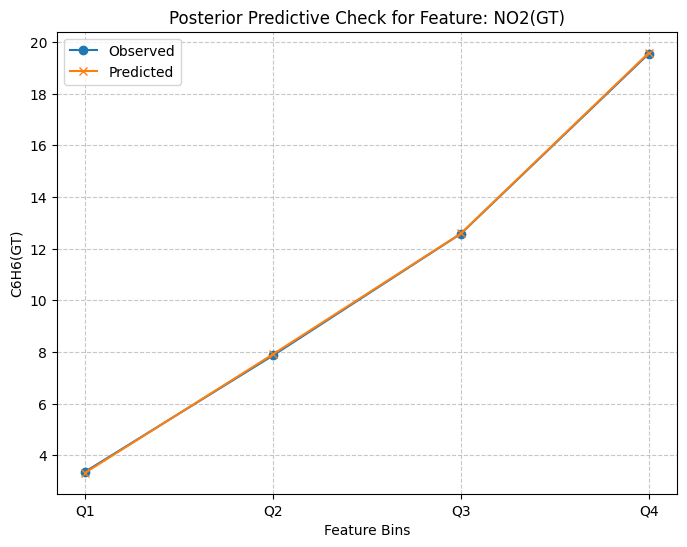

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


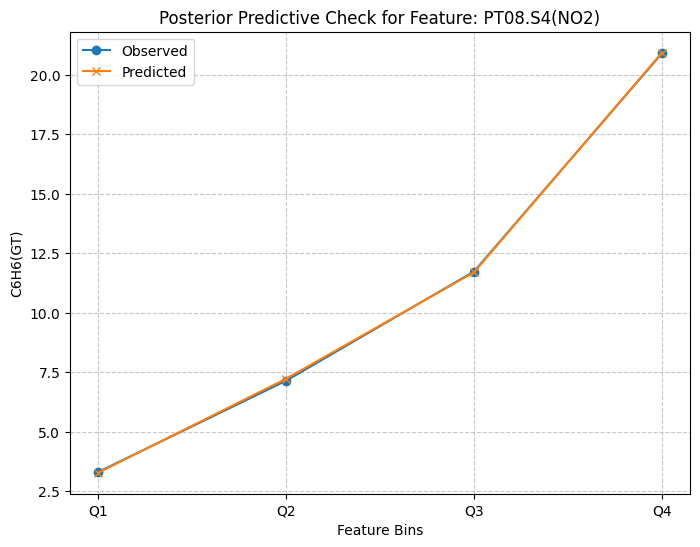

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


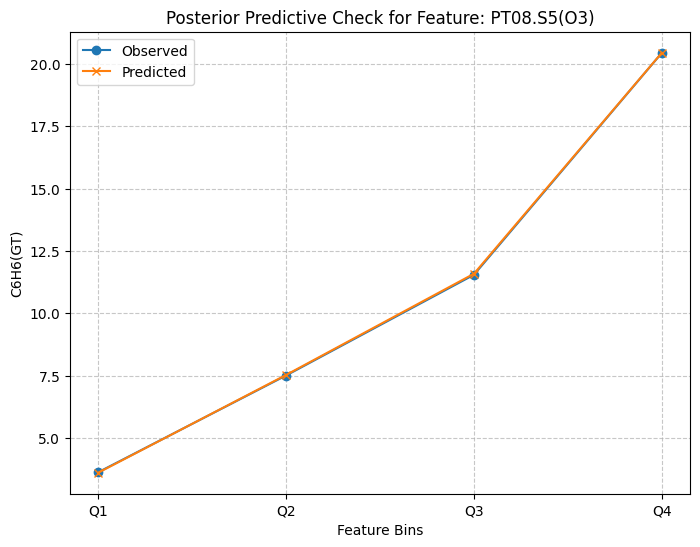

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


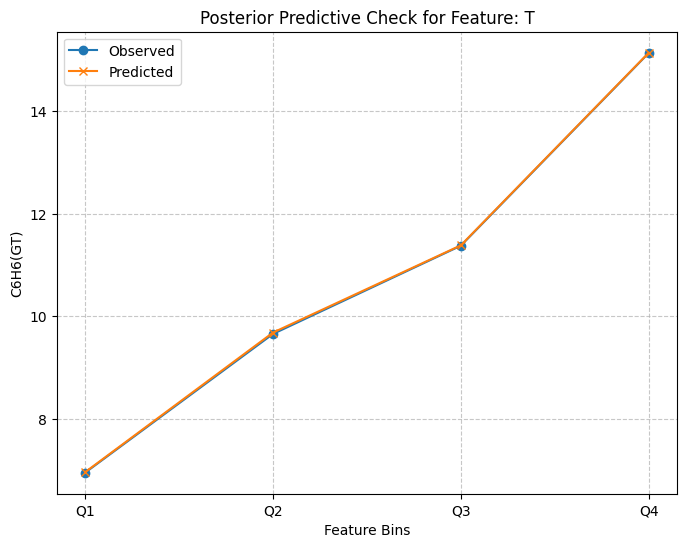

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


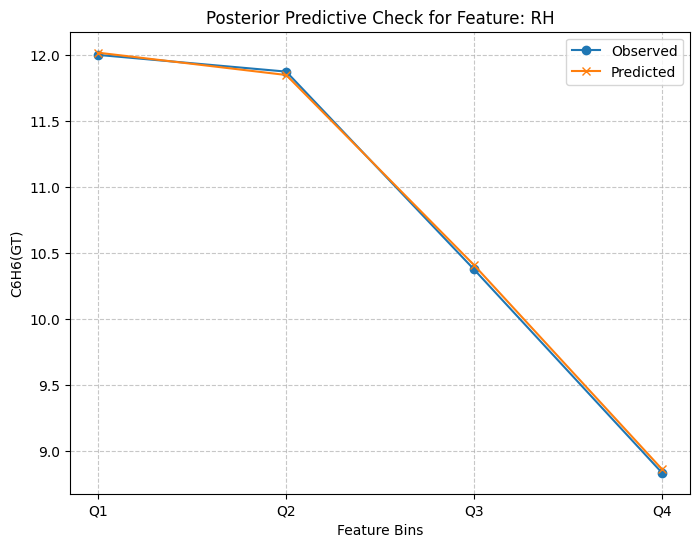

C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
C:\Users\mahmu\AppData\Local\Temp\ipykernel_44476\2805015333.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(f"{feature}_bin")["predicted"].mean()


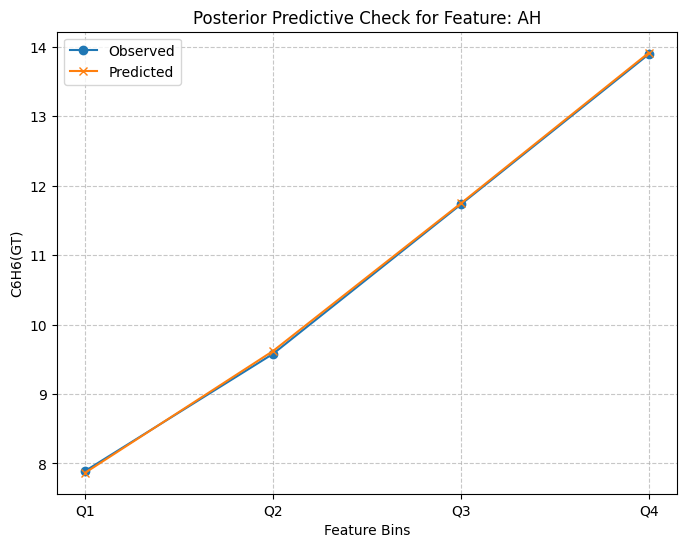

In [16]:
# Compute posterior predictive means for each observation
posterior_means = posterior_samples.mean(axis=0)  # Average over the draws

# Convert predictors to a DataFrame
X_scaled_df = pd.DataFrame(X, columns=predictor_columns)

# Iterate through each predictor
for feature in predictor_columns:
    # Bin the feature into quantiles for grouping
    bins = np.quantile(X_scaled_df[feature], [0, 0.25, 0.5, 0.75, 1.0])  # Quartiles
    bin_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    X_scaled_df[f"{feature}_bin"] = pd.cut(X_scaled_df[feature], bins=bins, labels=bin_labels, include_lowest=True)

    # Compute observed and predicted means for each bin
    observed_means = data.groupby(X_scaled_df[f"{feature}_bin"])["C6H6(GT)"].mean()
    predicted_means = pd.DataFrame({
        f"{feature}_bin": X_scaled_df[f"{feature}_bin"],
        "predicted": posterior_means
    }).groupby(f"{feature}_bin")["predicted"].mean()

    # Plot observed vs. predicted for the feature
    plt.figure(figsize=(8, 6))
    plt.plot(bin_labels, observed_means, label="Observed", marker="o")
    plt.plot(bin_labels, predicted_means, label="Predicted", marker="x")
    plt.title(f"Posterior Predictive Check for Feature: {feature}")
    plt.xlabel("Feature Bins")
    plt.ylabel("C6H6(GT)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


array([[<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 'mu_intercept'}>,
        <Axes: title={'center': 'mu_intercept'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_intercept'}>,
        <Axes: title={'center': 'sigma_intercept'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

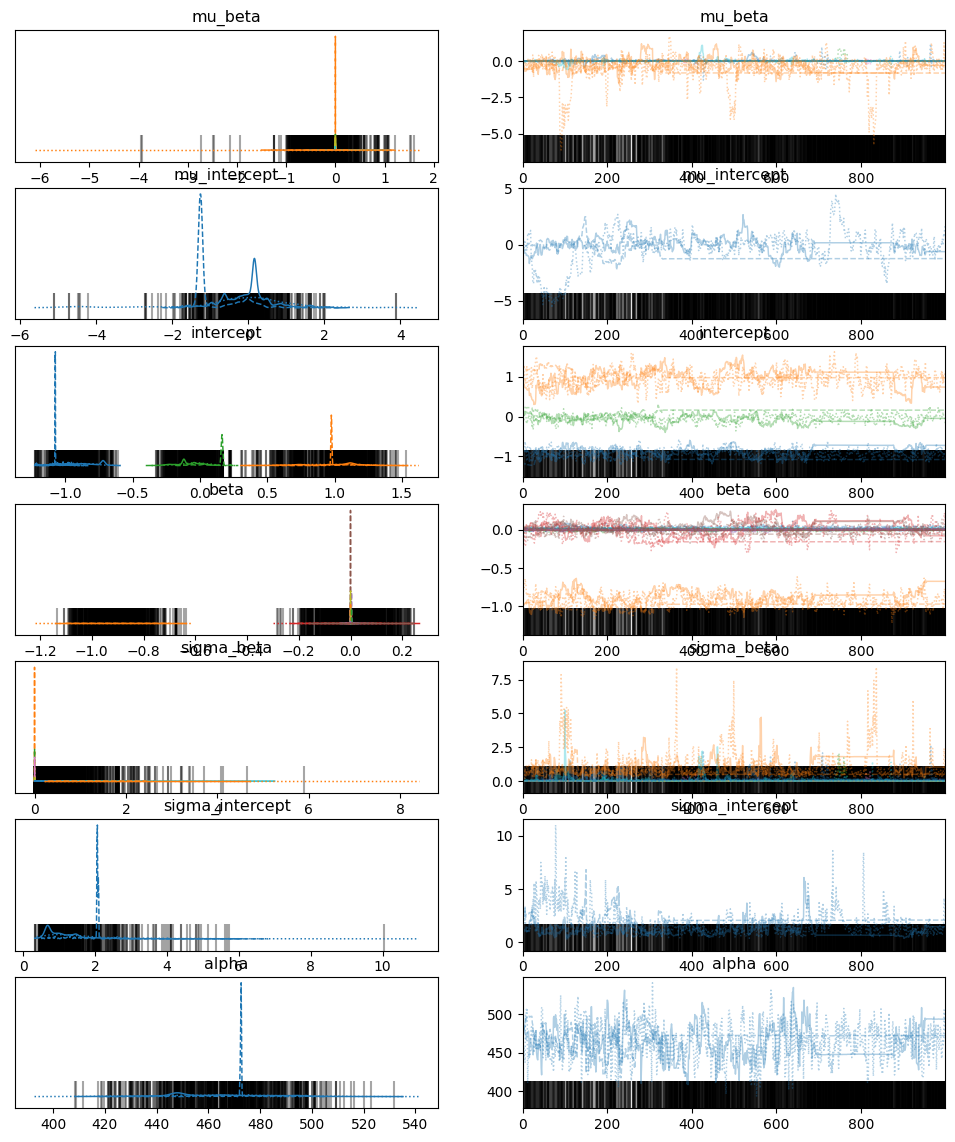

In [9]:
az.plot_trace(hierarchical_trace)

In [10]:
summary = az.summary(hierarchical_trace, round_to=2)
print(summary)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_beta[0]         0.01   0.09   -0.13     0.12       0.00     0.00    386.74   
mu_beta[1]         0.00   0.00   -0.00     0.00       0.00     0.00     52.09   
mu_beta[2]         0.00   0.05   -0.01     0.01       0.00     0.00     30.03   
mu_beta[3]         0.00   0.00   -0.00     0.01       0.00     0.00    316.44   
mu_beta[4]        -0.00   0.00   -0.01     0.00       0.00     0.00     40.94   
...                 ...    ...     ...      ...        ...      ...       ...   
sigma_beta[9]      0.06   0.17    0.01     0.17       0.01     0.01     33.87   
sigma_beta[10]     0.05   0.06    0.00     0.14       0.03     0.02      6.76   
sigma_beta[11]     0.94   0.77    0.25     1.97       0.14     0.10     25.23   
sigma_intercept    1.64   0.98    0.41     3.17       0.22     0.16     13.85   
alpha            465.45  20.16  421.47   499.21       1.40     0.99    227.90   

                 ess_tail  

Model Comparison

In [11]:
hierarchical_model

        mu_beta ~ Normal(0, 10)
     sigma_beta ~ HalfCauchy(0, 2)
   mu_intercept ~ Normal(0, 10)
sigma_intercept ~ HalfCauchy(0, 2)
      intercept ~ Normal(mu_intercept, sigma_intercept)
           beta ~ Normal(mu_beta, sigma_beta)
          alpha ~ HalfCauchy(0, 2)
         target ~ Gamma(alpha, f(alpha, intercept, beta))

In [12]:
with hierarchical_model:
    # Use logp_elemwise to compute log-likelihood for each observation
    pm.sample(
        1000, 
        tune=500, 
        init="adapt_diag", 
        return_inferencedata=True,
        log_likelihood=True
    )


Initializing NUTS using adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_beta, sigma_beta, mu_intercept, sigma_intercept, intercept, beta, alpha]


Output()

Sampling 3 chains for 500 tune and 1_000 draw iterations (1_500 + 3_000 draws total) took 351 seconds.
There were 1899 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
# Assuming hierarchical_trace contains the log-likelihood
waic = az.waic(hierarchical_trace)
loo = az.loo(hierarchical_trace)

print(f"WAIC: {waic.waic}, LOO: {loo.loo}")

TypeError: log likelihood not found in inference data object

In [20]:
# Compute WAIC and LOO
waic = az.waic(hierarchical_trace)
loo = az.loo(hierarchical_trace)

print(f"WAIC: {waic.waic}, LOO: {loo.loo}")

TypeError: log likelihood not found in inference data object